# GOAL: Calculate the factor of importance for US patents in 2001

# Prepare data

In [5]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from scipy.linalg import norm

## customize your own directory

In [4]:
data_home = r"C:\Users\Lingmin\Desktop\Patent_project\data"
local_lib = r"C:\Users\Lingmin\Desktop\Patent_project\lib"
data_prefix = 'g_detail_desc_text'
#csv_file = f"{data_home}/output/austen-persuasion.csv" 

In [5]:
import sys
sys.path.append(local_lib)

## Merge US patents from 1997-2003

In [6]:
# create an empty dataframe to store the data
all_data = pd.DataFrame()

# loop through the years you want to import
for year in range(1997, 2004):
    # construct the file name based on the year
    file_name = f"g_detail_desc_text_{year}"
    
    # read in the data and add a "year" column
    data = pd.read_csv(f"{data_home}/{file_name}.tsv", sep='\t').set_index('patent_id')
    data=data.drop('description_length', axis=1)
    data["year"] = year
    # append the data to the overall dataframe
    all_data = pd.concat([all_data, data], axis=0)

In [13]:
all_data

,description_text,year
patent_id,,
5590420,DETAILED DESCRIPTION OF THE INVENTION \nAs ind...,1997
5590421,DETAILED DESCRIPTION OF THE INVENTION \nAlthou...,1997
5590422,DETAILED DESCRIPTION OF THE INVENTION \nTurnin...,1997
5590423,EXEMPLARY MODE FOR CARRYING OUT THE INVENTION ...,1997
5590424,DETAILED DESCRIPTION OF THE INVENTION \nReferr...,1997
...,...,...
RE38372,BEST MODE FOR CARRYING OUT THE INVENTION \n\n ...,2003
RE38373,DETAILED DESCRIPTION OF THE \n\n PREFERRED EMB...,2003
RE38374,BEST MODE FOR CARRYING OUT THE INVENTION \n\n ...,2003


## Select a sublet of patents which belongs to AI_MachingLearning Category

In [7]:
df_ai = pd.read_stata('ai_model_predictions.dta')
df_ai['year'] = df_ai['pub_dt'].apply(lambda x: (x[:4]))
df_ai = df_ai[df_ai['year'] != '']
df_ai['year']=df_ai['year'].astype(int)
df_ai = df_ai[(df_ai['flag_patent'] == 1) & (df_ai['predict50_ml'] == 1) & (df_ai['year'] >= 1997) & (df_ai['year'] <= 2003)]

In [8]:
df_ai

,doc_id,flag_patent,pub_dt,appl_id,flag_train_any,predict50_any_ai,flag_train_ml,ai_score_ml,predict50_ml,flag_train_evo,...,ai_score_kr,predict50_kr,flag_train_planning,ai_score_planning,predict50_planning,flag_train_hardware,ai_score_hardware,predict50_hardware,analysis_phase,year
18907,6385286,1,2002-05-07,09582538,0,1,0,0.835756,1,0,...,0.993473,1,0,0.930862,1,0,0.234813,0,1,2002
19054,6418227,1,2002-07-09,08991726,0,1,0,0.675989,1,0,...,0.025012,0,0,0.010356,0,0,0.041158,0,1,2002
19074,6574613,1,2003-06-03,09403878,0,1,0,0.999266,1,0,...,0.992934,1,0,0.999317,1,0,0.779545,1,1,2003
19274,6616327,1,2003-09-09,09668913,0,1,0,0.677815,1,0,...,0.164779,0,0,0.005968,0,0,0.255478,0,1,2003
19299,6591369,1,2003-07-08,09410638,0,1,0,0.999849,1,0,...,0.001539,0,0,0.737369,1,0,0.999947,1,1,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11696005,6308271,1,2001-10-23,09083047,0,1,0,0.985574,1,0,...,0.074507,0,0,0.020109,0,0,0.037030,0,1,2001
11726526,5852815,1,1998-12-22,07079730,0,1,0,0.999434,1,0,...,0.995547,1,0,0.980349,1,0,0.883797,1,2,1998
11726527,5852816,1,1998-12-22,07079731,0,1,0,0.999703,1,0,...,0.998023,1,0,0.992728,1,0,0.993230,1,2,1998
11726593,5854991,1,1998-12-29,07067567,0,1,0,0.764140,1,0,...,0.973884,1,0,0.949116,1,0,0.459143,0,2,1998


In [9]:
df = pd.merge(df_ai, all_data, left_on = 'doc_id', right_on = 'patent_id', how='left').set_index('doc_id')


In [10]:
df = df[['description_text', 'year_y']]
df

,description_text,year_y
doc_id,,
6385286,DETAILED DESCRIPTION OF THE INVENTION \n\n The...,2002
6418227,DETAILED DESCRIPTION OF THE INVENTION \n\n FIG...,2002
6574613,DETAILED DESCRIPTION OF PRESENTLY PREFERRED EM...,2003
6616327,BEST MODES FOR CARRYING OUT THE INVENTION \n\n...,2003
6591369,DETAILED DESCRIPTION \n\n One embodiment of th...,2003
...,...,...
6308271,DETAILED DESCRIPTION OF THE PREFERRED EMBODIME...,2001
5852815,DETAILED DESCRIPTION OF THE DRAWINGS \nReferri...,1998
5852816,DETAILED DESCRIPTION OF THE DRAWINGS \nReferri...,1998


## Pickle the selected patent data,  remove numbers and punctuations, and to lower case

In [11]:
df0=df.copy()

In [12]:
df0['term_str']=df.description_text.replace(r'[^a-zA-Z]+', ' ', regex=True).str.lower()

In [13]:
df0=df0[["term_str","year_y"]]

In [14]:
df0

,term_str,year_y
doc_id,,
6385286,detailed description of the invention the radi...,2002
6418227,detailed description of the invention fig is a...,2002
6574613,detailed description of presently preferred em...,2003
6616327,best modes for carrying out the invention the ...,2003
6591369,detailed description one embodiment of the inv...,2003
...,...,...
6308271,detailed description of the preferred embodime...,2001
5852815,detailed description of the drawings referring...,1998
5852816,detailed description of the drawings referring...,1998


In [15]:
df0.to_pickle("/Users/Lingmin/Desktop/Patent_project/data/patents.pickle")

In [16]:
df0=pd.read_pickle("/Users/Lingmin/Desktop/Patent_project/data/patents.pickle")

In [17]:
df0

,term_str,year_y
doc_id,,
6385286,detailed description of the invention the radi...,2002
6418227,detailed description of the invention fig is a...,2002
6574613,detailed description of presently preferred em...,2003
6616327,best modes for carrying out the invention the ...,2003
6591369,detailed description one embodiment of the inv...,2003
...,...,...
6308271,detailed description of the preferred embodime...,2001
5852815,detailed description of the drawings referring...,1998
5852816,detailed description of the drawings referring...,1998


## Filter stop words

In [18]:
sw=nltk.corpus.stopwords.words('english')+[' ']+['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']\
+['fig','figure','figures','description','definition','detailed']

# Use CountVectorizer to generate DTCM

In [19]:
#generate corpus for vocab
corpus = ' '.join(df0['term_str'].tolist())

In [20]:
engine = CountVectorizer(stop_words=sw) 
bow_table = engine.fit_transform([corpus])  
vocab_table = engine.get_feature_names_out()

In [21]:
model = engine.fit_transform(df0.term_str)

In [22]:
wrds=list(vocab_table)
len(wrds)

211934

In [23]:
col_sums = np.array(model.sum(axis=0))[0]

# filter word by frequency

In [24]:
minlen=100
maxlen=0.8*len(wrds)

In [25]:
condition = (col_sums > minlen) & (col_sums < maxlen) 

In [31]:
filtered_elements = col_sums[condition] # kept words
filtered_indexes = np.where(condition)[0] #index of kept words

In [32]:
model_filtered=model[:,filtered_indexes] # model after filter
wrds_filtered=[wrds[i] for i in filtered_indexes] #list of kept words, to use as DTCM column
wrds_deleted=[wrds[i] for i in range(len(wrds)) if i not in filtered_indexes] #check what words are removed

In [33]:
#print(wrds_deleted)

In [34]:
DTCM = pd.DataFrame(model_filtered.toarray(), columns=wrds_filtered)

In [36]:
DTCM.index=df0.index

In [37]:
DTCM

,aa,aaa,aac,aag,aal,aat,ab,abandoned,abbreviated,abbreviation,...,zone,zones,zoo,zoom,zooming,zp,zr,zs,zv,zz
doc_id,,,,,,,,,,,,,,,,,,,,,
6385286,0,0,0,0,0,0,0,0,0,0,...,3,12,0,0,0,0,0,0,0,0
6418227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6574613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6616327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6591369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6308271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5852815,1,0,11,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5852816,1,0,11,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Could add year to DTCM, not necessary for now

In [39]:
# DTCM_new=DTCM.merge(df0['year_y'].to_frame('year'), on='doc_id',how='left')

## Calculate TFBIDF (Not TFIDF due to time dimension of patent) 

In [42]:
#Parameters
tf_method='sum'

## TF, same as in the class

In [43]:
print('TF method:', tf_method)
if tf_method == 'sum':
    TF = DTCM.T / DTCM.T.sum()
elif tf_method == 'max':
    TF = DTCM.T / DTCM.T.max()
elif tf_method == 'log':
    TF = np.log2(1 + DTCM.T)
elif tf_method == 'raw':
    TF = DTCM.T
elif tf_method == 'double_norm':
    TF = DTCM.T / DTCM.T.max()
elif tf_method == 'binary':
    TF = DTCM.T.astype('bool').astype('int')
TF = TF.T

TF method: sum


## BIDF(Backward-IDF)

In [ ]:
## Boolean model

In [45]:
BIDF_0=DTCM.astype('bool').merge(df0['year_y'].to_frame('year'), on='doc_id',how='left')

In [46]:
BIDF_0

,aa,aaa,aac,aag,aal,aat,ab,abandoned,abbreviated,abbreviation,...,zones,zoo,zoom,zooming,zp,zr,zs,zv,zz,year_y
doc_id,,,,,,,,,,,,,,,,,,,,,
6385286,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,2002
6418227,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2002
6574613,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2003
6616327,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2003
6591369,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6308271,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2001
5852815,True,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1998
5852816,True,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1998


## number of documents in each year

In [50]:
BIDF_1=BIDF_0.year_y.value_counts().to_frame('doc_num')

In [51]:
BIDF_1.index.name='year_y'

In [52]:
BIDF_1

,doc_num
year_y,
2003,1598
2002,1505
1998,1435
2001,1361
1999,1315
2000,1281
1997,904


## term frequency in each year

In [53]:
BIDF_2=DTCM.astype('bool').merge(df0['year_y'].to_frame('year'), on='doc_id',how='left').groupby('year_y').sum()

In [54]:
BIDF_2

,aa,aaa,aac,aag,aal,aat,ab,abandoned,abbreviated,abbreviation,...,zone,zones,zoo,zoom,zooming,zp,zr,zs,zv,zz
year_y,,,,,,,,,,,,,,,,,,,,,
1997,21,2,1,0,0,0,35,14,24,16,...,51,20,2,10,6,5,5,3,3,2
1998,36,7,7,4,1,0,67,18,35,20,...,73,32,5,15,5,5,3,4,3,9
1999,38,13,9,10,1,9,47,15,34,16,...,74,49,4,22,12,1,3,4,3,5
2000,42,17,13,9,2,8,56,19,27,8,...,69,52,4,20,7,0,2,0,1,5
2001,26,15,14,7,1,8,64,8,27,15,...,88,51,2,25,11,1,5,1,0,9
2002,45,27,21,21,2,21,101,25,41,23,...,101,65,3,23,13,1,5,3,3,3
2003,42,11,10,7,5,6,73,15,27,19,...,108,70,4,28,14,3,5,6,1,11


In [55]:
## merge the above two

In [56]:
BIDF_3=BIDF_2.merge(BIDF_1, on='year_y',how='left')

In [57]:
BIDF_3

,aa,aaa,aac,aag,aal,aat,ab,abandoned,abbreviated,abbreviation,...,zones,zoo,zoom,zooming,zp,zr,zs,zv,zz,doc_num
year_y,,,,,,,,,,,,,,,,,,,,,
1997,21,2,1,0,0,0,35,14,24,16,...,20,2,10,6,5,5,3,3,2,904
1998,36,7,7,4,1,0,67,18,35,20,...,32,5,15,5,5,3,4,3,9,1435
1999,38,13,9,10,1,9,47,15,34,16,...,49,4,22,12,1,3,4,3,5,1315
2000,42,17,13,9,2,8,56,19,27,8,...,52,4,20,7,0,2,0,1,5,1281
2001,26,15,14,7,1,8,64,8,27,15,...,51,2,25,11,1,5,1,0,9,1361
2002,45,27,21,21,2,21,101,25,41,23,...,65,3,23,13,1,5,3,3,3,1505
2003,42,11,10,7,5,6,73,15,27,19,...,70,4,28,14,3,5,6,1,11,1598


In [ ]:
# Calculate the no. of times a word appears in previous 2 years, and no.of previous patents in each year (window length=2)

In [58]:
BIDF_4=BIDF_3.rolling(window=2,min_periods=1).sum().shift(1)

In [59]:
BIDF_4

,aa,aaa,aac,aag,aal,aat,ab,abandoned,abbreviated,abbreviation,...,zones,zoo,zoom,zooming,zp,zr,zs,zv,zz,doc_num
year_y,,,,,,,,,,,,,,,,,,,,,
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,21.0,2.0,1.0,0.0,0.0,0.0,35.0,14.0,24.0,16.0,...,20.0,2.0,10.0,6.0,5.0,5.0,3.0,3.0,2.0,904.0
1999,57.0,9.0,8.0,4.0,1.0,0.0,102.0,32.0,59.0,36.0,...,52.0,7.0,25.0,11.0,10.0,8.0,7.0,6.0,11.0,2339.0
2000,74.0,20.0,16.0,14.0,2.0,9.0,114.0,33.0,69.0,36.0,...,81.0,9.0,37.0,17.0,6.0,6.0,8.0,6.0,14.0,2750.0
2001,80.0,30.0,22.0,19.0,3.0,17.0,103.0,34.0,61.0,24.0,...,101.0,8.0,42.0,19.0,1.0,5.0,4.0,4.0,10.0,2596.0
2002,68.0,32.0,27.0,16.0,3.0,16.0,120.0,27.0,54.0,23.0,...,103.0,6.0,45.0,18.0,1.0,7.0,1.0,1.0,14.0,2642.0
2003,71.0,42.0,35.0,28.0,3.0,29.0,165.0,33.0,68.0,38.0,...,116.0,5.0,48.0,24.0,2.0,10.0,4.0,3.0,12.0,2866.0


## Similarity of two patents

Suppose two patents 1 and 2. 1 was invented before 2. Use TF-BIDF to characterize each patent.

$$TF_{w,i} = \frac{c_{w,i}}{\sum_k c_{k,i}}\rightarrow \text{Frequency of word w in patent i}$$

$$BIDF_{w,i,j} = \log\left(\frac{\text{# of patents prior to }h}{1+\text{# of patents prior to h that include word w}}\right), h = \min\{1,2\}\rightarrow\text{downweigh words that appear frequently in the corpus}$$

$$TF-BIDF_{w,i,j}=TF_{w,i}\times BIDF_{w,i,j}$$

## The denominator in formula above

In [60]:
BIDF_5=BIDF_4.iloc[:,:-1]+1

In [61]:
BIDF_5

,aa,aaa,aac,aag,aal,aat,ab,abandoned,abbreviated,abbreviation,...,zone,zones,zoo,zoom,zooming,zp,zr,zs,zv,zz
year_y,,,,,,,,,,,,,,,,,,,,,
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,22.0,3.0,2.0,1.0,1.0,1.0,36.0,15.0,25.0,17.0,...,52.0,21.0,3.0,11.0,7.0,6.0,6.0,4.0,4.0,3.0
1999,58.0,10.0,9.0,5.0,2.0,1.0,103.0,33.0,60.0,37.0,...,125.0,53.0,8.0,26.0,12.0,11.0,9.0,8.0,7.0,12.0
2000,75.0,21.0,17.0,15.0,3.0,10.0,115.0,34.0,70.0,37.0,...,148.0,82.0,10.0,38.0,18.0,7.0,7.0,9.0,7.0,15.0
2001,81.0,31.0,23.0,20.0,4.0,18.0,104.0,35.0,62.0,25.0,...,144.0,102.0,9.0,43.0,20.0,2.0,6.0,5.0,5.0,11.0
2002,69.0,33.0,28.0,17.0,4.0,17.0,121.0,28.0,55.0,24.0,...,158.0,104.0,7.0,46.0,19.0,2.0,8.0,2.0,2.0,15.0
2003,72.0,43.0,36.0,29.0,4.0,30.0,166.0,34.0,69.0,39.0,...,190.0,117.0,6.0,49.0,25.0,3.0,11.0,5.0,4.0,13.0


## Numerator in the above formula

In [63]:
BIDF_6=BIDF_4.iloc[:,[-1]]

In [64]:
BIDF_6

,doc_num
year_y,
1997,NaN
1998,904.0
1999,2339.0
2000,2750.0
2001,2596.0
2002,2642.0
2003,2866.0


## BIDF

In [66]:
BIDF=pd.DataFrame(np.divide(BIDF_6.values, BIDF_5.values), columns=BIDF_5.columns)
BIDF.index=BIDF_6.index
BIDF=np.log2(BIDF)

In [68]:
BIDF

,aa,aaa,aac,aag,aal,aat,ab,abandoned,abbreviated,abbreviation,...,zone,zones,zoo,zoom,zooming,zp,zr,zs,zv,zz
year_y,,,,,,,,,,,,,,,,,,,,,
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,5.360747,8.235216,8.820179,9.820179,9.820179,9.820179,4.650254,5.913288,5.176323,5.732716,...,4.119739,5.427862,8.235216,6.360747,7.012824,7.235216,7.235216,7.820179,7.820179,8.235216
1999,5.333695,7.869748,8.021751,8.869748,10.191676,11.191676,4.505176,6.147282,5.284786,5.982223,...,4.225892,5.463756,8.191676,6.491236,7.606714,7.732245,8.021751,8.191676,8.384321,7.606714
2000,5.196397,7.032898,7.337753,7.518325,9.840253,8.103288,4.579726,6.337753,5.295933,6.215763,...,4.215763,5.067664,8.103288,6.177288,7.255291,8.617861,8.617861,8.255291,8.617861,7.518325
2001,5.002225,6.387878,6.818513,7.020147,9.342075,7.172150,4.641635,6.212792,5.387878,6.698218,...,4.172150,4.669649,8.172150,5.915810,7.020147,10.342075,8.757112,9.020147,9.020147,7.882643
2002,5.258890,6.323021,6.560060,7.279952,9.367415,7.279952,4.448552,6.560060,5.586055,6.782452,...,4.063634,4.666975,8.560060,5.843853,7.119487,10.367415,8.367415,10.367415,10.367415,7.460524
2003,5.314898,6.058558,6.314898,6.626842,9.484823,6.577932,4.109783,6.397360,5.376298,6.199421,...,3.914967,4.614458,8.899860,5.870113,6.840967,9.899860,8.025391,9.162895,9.484823,7.784383


## Tf with year column

In [69]:
TF_wy=TF.merge(df0['year_y'].to_frame('year'), on='doc_id',how='left').reset_index().drop('doc_id',axis=1).set_index(['year_y'])

In [70]:
TF_wy

,aa,aaa,aac,aag,aal,aat,ab,abandoned,abbreviated,abbreviation,...,zone,zones,zoo,zoom,zooming,zp,zr,zs,zv,zz
year_y,,,,,,,,,,,,,,,,,,,,,
2002,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.001451,0.005806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2002,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2003,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2003,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2003,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1998,0.000226,0.0,0.002485,0.0,0.0,0.0,0.000678,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1998,0.000226,0.0,0.002485,0.0,0.0,0.0,0.000678,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## In the end, generate TFBIDF

In [78]:
TFBIDF_0=TF_wy.apply(lambda row: row.multiply(BIDF.loc[row.name], fill_value=1), axis=1)

In [79]:
TFBIDF_0['doc_id']=df0.index

In [80]:
TFBIDF=TFBIDF_0.reset_index().set_index(['doc_id','year_y'])

In [81]:
TFBIDF

,,aa,aaa,aac,aag,aal,aat,ab,abandoned,abbreviated,abbreviation,...,zone,zones,zoo,zoom,zooming,zp,zr,zs,zv,zz
doc_id,year_y,,,,,,,,,,,,,,,,,,,,,
6385286,2002,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.005898,0.027094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6418227,2002,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6574613,2003,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6616327,2003,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6591369,2003,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6308271,2001,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5852815,1998,0.001211,0.0,0.021916,0.0,0.0,0.0,0.003151,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5852816,1998,0.001211,0.0,0.021921,0.0,0.0,0.0,0.003152,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# PCA


## check how many components to choose, found 2000 is fine(which keeps > 80% variance)

In [83]:
pca = PCA(n_components=2000)
# fit the PCA to your data
pca.fit(TFBIDF)

PCA(n_components=2000)

In [24]:
import matplotlib.pyplot as plt

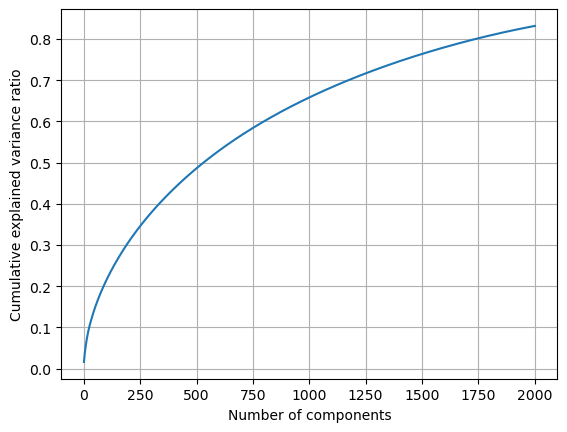

In [86]:
# calculate the cumulative explained variance ratio for each PC
cumulative_evr = np.cumsum(pca.explained_variance_ratio_)

# plot the cumulative EVR as a function of the number of components
plt.plot(range(1, len(cumulative_evr)+1), cumulative_evr)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.grid()
plt.show()

## Calculate L2 norm and normalize TFBIDF table

In [89]:
TFBIDF_L2 = (TFBIDF.T / norm(TFBIDF, 2, axis=1)).T

In [91]:
TFBIDF_L2 = TFBIDF_L2 - TFBIDF_L2.mean()

In [92]:
TFBIDF_L2

,,aa,aaa,aac,aag,aal,aat,ab,abandoned,abbreviated,abbreviation,...,zone,zones,zoo,zoom,zooming,zp,zr,zs,zv,zz
doc_id,year_y,,,,,,,,,,,,,,,,,,,,,
6385286,2002,-0.000737,-0.000197,-0.000389,-0.000223,-0.000127,-0.000115,-0.001068,-0.000301,-0.000196,-0.000121,...,0.013469,0.072049,-0.000231,-0.000295,-0.000095,-0.000075,-0.000146,-0.000148,-0.000049,-0.000233
6418227,2002,-0.000737,-0.000197,-0.000389,-0.000223,-0.000127,-0.000115,-0.001068,-0.000301,-0.000196,-0.000121,...,-0.002438,-0.001026,-0.000231,-0.000295,-0.000095,-0.000075,-0.000146,-0.000148,-0.000049,-0.000233
6574613,2003,-0.000737,-0.000197,-0.000389,-0.000223,-0.000127,-0.000115,-0.001068,-0.000301,-0.000196,-0.000121,...,-0.002438,-0.001026,-0.000231,-0.000295,-0.000095,-0.000075,-0.000146,-0.000148,-0.000049,-0.000233
6616327,2003,-0.000737,-0.000197,-0.000389,-0.000223,-0.000127,-0.000115,-0.001068,-0.000301,-0.000196,-0.000121,...,-0.002438,-0.001026,-0.000231,-0.000295,-0.000095,-0.000075,-0.000146,-0.000148,-0.000049,-0.000233
6591369,2003,-0.000737,-0.000197,-0.000389,-0.000223,-0.000127,-0.000115,-0.001068,-0.000301,-0.000196,-0.000121,...,-0.002438,-0.001026,-0.000231,-0.000295,-0.000095,-0.000075,-0.000146,-0.000148,-0.000049,-0.000233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6308271,2001,-0.000737,-0.000197,-0.000389,-0.000223,-0.000127,-0.000115,-0.001068,-0.000301,-0.000196,-0.000121,...,-0.002438,-0.001026,-0.000231,-0.000295,-0.000095,-0.000075,-0.000146,-0.000148,-0.000049,-0.000233
5852815,1998,0.006440,-0.000197,0.129505,-0.000223,-0.000127,-0.000115,0.017609,-0.000301,-0.000196,-0.000121,...,-0.002438,-0.001026,-0.000231,-0.000295,-0.000095,-0.000075,-0.000146,-0.000148,-0.000049,-0.000233
5852816,1998,0.006441,-0.000197,0.129524,-0.000223,-0.000127,-0.000115,0.017612,-0.000301,-0.000196,-0.000121,...,-0.002438,-0.001026,-0.000231,-0.000295,-0.000095,-0.000075,-0.000146,-0.000148,-0.000049,-0.000233


# Table of documents and components.


In [93]:
DCM_sk = pd.DataFrame(pca.fit_transform(TFBIDF_L2), index=TFBIDF_L2.index)

In [94]:
DCM_sk.columns = ['PC{}'.format(i) for i in DCM_sk.columns]


In [95]:
DCM_sk

,,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC1990,PC1991,PC1992,PC1993,PC1994,PC1995,PC1996,PC1997,PC1998,PC1999
doc_id,year_y,,,,,,,,,,,,,,,,,,,,,
6385286,2002,-0.080440,-0.002536,0.062580,0.030993,0.037097,0.006820,-0.054112,-0.018503,-0.001173,-0.036664,...,0.014321,0.004542,-0.007043,0.008250,0.004993,0.011029,-0.000435,-0.016605,0.006858,-0.000022
6418227,2002,0.060939,0.097638,-0.046609,0.113728,0.033388,-0.005014,-0.085165,-0.076523,0.022818,-0.094289,...,0.005477,0.004941,-0.000230,-0.002518,0.007920,0.003441,0.000666,0.000257,-0.003927,0.009901
6574613,2003,0.263077,-0.029540,0.177631,-0.095207,-0.209868,0.113001,-0.113510,-0.168049,-0.027579,0.018017,...,-0.010373,0.002446,0.002328,-0.012261,-0.000111,-0.011984,-0.003907,-0.008117,-0.012554,-0.000069
6616327,2003,-0.087885,0.006850,0.031371,0.019527,0.003410,0.008141,-0.036552,-0.007478,-0.016022,-0.008831,...,-0.011891,-0.001995,-0.003050,0.000403,-0.000689,0.003049,0.007945,0.005069,0.007561,0.009298
6591369,2003,-0.019049,0.180649,-0.173500,-0.049493,0.061629,0.055486,0.110956,-0.114064,-0.145319,-0.071194,...,-0.000997,-0.013720,0.007910,0.004407,-0.007348,0.000980,-0.007388,-0.003269,-0.008374,0.002146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6308271,2001,-0.037800,0.006285,-0.034096,-0.056136,-0.005446,-0.054491,-0.030884,-0.025992,0.049276,-0.024390,...,-0.006990,-0.014384,-0.004944,-0.012852,-0.012488,-0.000666,-0.005818,0.004241,0.008577,-0.008304
5852815,1998,0.268497,-0.027680,0.246313,-0.134533,-0.363111,0.194016,0.082742,-0.115074,0.009628,-0.044082,...,-0.003626,-0.003669,-0.000442,0.004803,-0.005066,-0.001588,-0.006447,0.006198,0.003860,0.001427
5852816,1998,0.268485,-0.027676,0.246304,-0.134598,-0.363139,0.194070,0.082813,-0.115124,0.009675,-0.044063,...,-0.003622,-0.003633,-0.000266,0.004826,-0.004996,-0.001374,-0.006626,0.006259,0.003846,0.001385


In [96]:
DCM_sk.to_pickle("/Users/Lingmin/Desktop/Patent_project/data/DMC_sk.pickle")

In [102]:
DCM_sk.to_csv(f'/Users/Lingmin/Desktop/Patent_project/data/DCM_sk.csv')

# the “loadings”

In [97]:
LOADINGS_sk = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_))
LOADINGS_sk.columns = ["PC{}".format(i) for i in LOADINGS_sk.columns]


In [98]:
LOADINGS_sk.index = TFBIDF_L2.columns
LOADINGS_sk.index.name = 'term_str'

In [99]:
LOADINGS_sk

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC1990,PC1991,PC1992,PC1993,PC1994,PC1995,PC1996,PC1997,PC1998,PC1999
term_str,,,,,,,,,,,,,,,,,,,,,
aa,-0.000294,-0.000179,0.000248,0.000305,-0.000337,-0.000196,0.000259,0.000171,-0.000079,0.000065,...,0.000003,-0.000188,0.000121,0.000244,-0.000010,-0.000065,-0.000035,2.262531e-07,-0.000399,2.956824e-08
aaa,-0.000229,-0.000021,0.000178,0.000152,-0.000217,-0.000047,0.000323,0.000003,-0.000068,0.000155,...,-0.000014,0.000002,0.000023,-0.000014,-0.000003,0.000044,0.000038,-1.396295e-06,0.000058,-3.232391e-06
aac,-0.000019,-0.000034,0.000443,0.000053,-0.000689,0.000090,0.000415,-0.000193,-0.000060,0.000091,...,0.000039,-0.000011,0.000062,0.000059,0.000023,-0.000010,-0.000048,6.701185e-05,-0.000046,-2.146235e-05
aag,-0.000407,0.000023,0.000306,0.000295,-0.000408,-0.000124,0.000544,-0.000033,-0.000105,0.000299,...,-0.000018,0.000011,-0.000030,0.000033,0.000048,0.000003,0.000003,6.689975e-06,0.000024,-1.199162e-05
aal,-0.000061,0.000023,-0.000038,-0.000058,-0.000049,0.000023,0.000005,-0.000028,-0.000067,-0.000060,...,0.000014,-0.000073,-0.000112,-0.000010,0.000094,0.000118,-0.000197,2.766156e-05,-0.000022,2.004459e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zp,0.000030,0.000019,-0.000028,0.000049,0.000044,-0.000027,0.000002,-0.000004,-0.000068,-0.000028,...,-0.000024,-0.000028,-0.000015,0.000008,0.000024,0.000002,-0.000009,-2.923215e-05,-0.000083,-2.155716e-06
zr,0.000020,0.000081,0.000011,0.000033,0.000037,-0.000090,-0.000066,-0.000021,-0.000132,0.000286,...,0.000052,0.000138,0.000107,0.000028,0.000094,0.000003,0.000083,1.810062e-04,-0.000026,-4.542739e-05
zs,-0.000010,0.000025,-0.000015,0.000035,-0.000039,-0.000041,-0.000132,-0.000006,-0.000044,0.000167,...,0.000038,-0.000042,0.000021,-0.000011,-0.000067,-0.000021,-0.000020,-1.842935e-04,-0.000136,7.154697e-05


In [9]:
LOADINGS_sk.to_csv(f'/Users/Lingmin/Desktop/Patent_project/data/LOADINGS_sk.csv')

In [10]:
LOADINGS_sk.to_pickle("/Users/Lingmin/Desktop/Patent_project/data/LOADINGS_sk.pickle")

# Measure Similarity

## Create Doc Pair Table


### drop 1997 and 1998 since they don't have property measured BIDF(window=2)

In [6]:
LOADINGS_sk=pd.read_pickle("/Users/Lingmin/Desktop/Patent_project/data/LOADINGS_sk.pickle")

In [12]:
DCM_sk=pd.read_pickle("/Users/Lingmin/Desktop/Patent_project/data/DMC_sk.pickle")

In [13]:
DCM_sk_filtered = DCM_sk.drop(index=[1997,1998], level=1)
DCM_sk_filtered

,,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC1990,PC1991,PC1992,PC1993,PC1994,PC1995,PC1996,PC1997,PC1998,PC1999
doc_id,year_y,,,,,,,,,,,,,,,,,,,,,
6385286,2002,-0.080440,-0.002536,0.062580,0.030993,0.037097,0.006820,-0.054112,-0.018503,-0.001173,-0.036664,...,0.014321,0.004542,-0.007043,0.008250,0.004993,0.011029,-0.000435,-0.016605,0.006858,-0.000022
6418227,2002,0.060939,0.097638,-0.046609,0.113728,0.033388,-0.005014,-0.085165,-0.076523,0.022818,-0.094289,...,0.005477,0.004941,-0.000230,-0.002518,0.007920,0.003441,0.000666,0.000257,-0.003927,0.009901
6574613,2003,0.263077,-0.029540,0.177631,-0.095207,-0.209868,0.113001,-0.113510,-0.168049,-0.027579,0.018017,...,-0.010373,0.002446,0.002328,-0.012261,-0.000111,-0.011984,-0.003907,-0.008117,-0.012554,-0.000069
6616327,2003,-0.087885,0.006850,0.031371,0.019527,0.003410,0.008141,-0.036552,-0.007478,-0.016022,-0.008831,...,-0.011891,-0.001995,-0.003050,0.000403,-0.000689,0.003049,0.007945,0.005069,0.007561,0.009298
6591369,2003,-0.019049,0.180649,-0.173500,-0.049493,0.061629,0.055486,0.110956,-0.114064,-0.145319,-0.071194,...,-0.000997,-0.013720,0.007910,0.004407,-0.007348,0.000980,-0.007388,-0.003269,-0.008374,0.002146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6507809,2003,-0.069649,0.032578,-0.045880,-0.054707,-0.004379,-0.034360,-0.015876,-0.012208,-0.002744,-0.038233,...,-0.013236,-0.012580,-0.009439,-0.007918,0.014635,-0.003716,-0.006370,0.005149,0.006934,0.002098
6278401,2001,-0.022607,-0.027837,0.026601,0.039498,0.029212,-0.058007,-0.045102,0.041611,-0.023106,-0.024744,...,0.009031,0.009762,0.007440,-0.010478,-0.011942,0.005434,0.005197,-0.015332,0.005503,0.005888
6269171,2001,-0.010703,-0.094011,0.012055,-0.027836,0.125330,0.087597,0.054070,-0.028441,-0.018476,0.028970,...,0.023796,-0.008790,0.006297,0.017797,0.000823,-0.020775,-0.002416,0.004064,0.009572,0.027094


In [14]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DCM_sk_filtered.index.tolist(), DCM_sk_filtered.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['patent_a', 'patent_b']

In [15]:
PAIRS

Empty DataFrame
Columns: []
Index: [((6385286, 2002), (6418227, 2002)), ((6385286, 2002), (6574613, 2003)), ((6385286, 2002), (6616327, 2003)), ((6385286, 2002), (6591369, 2003)), ((6385286, 2002), (6473889, 2002)), ((6385286, 2002), (6628844, 2003)), ((6385286, 2002), (6434408, 2002)), ((6385286, 2002), (6560586, 2003)), ((6385286, 2002), (6464410, 2002)), ((6385286, 2002), (6502082, 2002)), ((6385286, 2002), (6561980, 2003)), ((6385286, 2002), (6459939, 2002)), ((6385286, 2002), (6466858, 2002)), ((6385286, 2002), (6633783, 2003)), ((6385286, 2002), (6606597, 2003)), ((6385286, 2002), (6389405, 2002)), ((6385286, 2002), (6484298, 2002)), ((6385286, 2002), (6430513, 2002)), ((6385286, 2002), (6496189, 2002)), ((6385286, 2002), (6465472, 2002)), ((6385286, 2002), (6652287, 2003)), ((6385286, 2002), (6553536, 2003)), ((6385286, 2002), (6584165, 2003)), ((6385286, 2002), (6408402, 2002)), ((6385286, 2002), (6438493, 2002)), ((6385286, 2002), (6544739, 2003)), ((6385286, 2002), (6556659, 2003)), ((6385286, 2002), (6485486, 2002)), ((6385286, 2002), (6606614, 2003)), ((6385286, 2002), (6636978, 2003)), ((6385286, 2002), (6425350, 2002)), ((6385286, 2002), (6484123, 2002)), ((6385286, 2002), (6628163, 2003)), ((6385286, 2002), (6578021, 2003)), ((6385286, 2002), (6640191, 2003)), ((6385286, 2002), (6468476, 2002)), ((6385286, 2002), (6633181, 2003)), ((6385286, 2002), (6658377, 2003)), ((6385286, 2002), (6549038, 2003)), ((6385286, 2002), (6639668, 2003)), ((6385286, 2002), (6435508, 2002)), ((6385286, 2002), (6598047, 2003)), ((6385286, 2002), (6473747, 2002)), ((6385286, 2002), (6498581, 2002)), ((6385286, 2002), (6560360, 2003)), ((6385286, 2002), (6460025, 2002)), ((6385286, 2002), (6574787, 2003)), ((6385286, 2002), (6597959, 2003)), ((6385286, 2002), (6442287, 2002)), ((6385286, 2002), (6434522, 2002)), ((6385286, 2002), (6666801, 2003)), ((6385286, 2002), (6581048, 2003)), ((6385286, 2002), (6618678, 2003)), ((6385286, 2002), (6460172, 2002)), ((6385286, 2002), (6620100, 2003)), ((6385286, 2002), (6391552, 2002)), ((6385286, 2002), (6624718, 2003)), ((6385286, 2002), (6561930, 2003)), ((6385286, 2002), (6541713, 2003)), ((6385286, 2002), (6449972, 2002)), ((6385286, 2002), (6397136, 2002)), ((6385286, 2002), (6456738, 2002)), ((6385286, 2002), (6393075, 2002)), ((6385286, 2002), (6457362, 2002)), ((6385286, 2002), (6608944, 2003)), ((6385286, 2002), (6622135, 2003)), ((6385286, 2002), (6622287, 2003)), ((6385286, 2002), (6463488, 2002)), ((6385286, 2002), (6640121, 2003)), ((6385286, 2002), (6453307, 2002)), ((6385286, 2002), (6438552, 2002)), ((6385286, 2002), (6625759, 2003)), ((6385286, 2002), (6460034, 2002)), ((6385286, 2002), (6385600, 2002)), ((6385286, 2002), (6584468, 2003)), ((6385286, 2002), (6661908, 2003)), ((6385286, 2002), (6615333, 2003)), ((6385286, 2002), (6564184, 2003)), ((6385286, 2002), (6667740, 2003)), ((6385286, 2002), (6553252, 2003)), ((6385286, 2002), (6392386, 2002)), ((6385286, 2002), (6549719, 2003)), ((6385286, 2002), (6604189, 2003)), ((6385286, 2002), (6560755, 2003)), ((6385286, 2002), (6431875, 2002)), ((6385286, 2002), (6445978, 2002)), ((6385286, 2002), (6569624, 2003)), ((6385286, 2002), (6429882, 2002)), ((6385286, 2002), (6411833, 2002)), ((6385286, 2002), (6395487, 2002)), ((6385286, 2002), (6670852, 2003)), ((6385286, 2002), (6430624, 2002)), ((6385286, 2002), (6601048, 2003)), ((6385286, 2002), (6411373, 2002)), ((6385286, 2002), (6659774, 2003)), ((6385286, 2002), (6418424, 2002)), ((6385286, 2002), (6587466, 2003)), ((6385286, 2002), (6430454, 2002)), ((6385286, 2002), (6408428, 2002)), ((6385286, 2002), (6473825, 2002)), ...]

[24918270 rows x 0 columns]

In [ ]:
## calculate pair-wise cosine distance

In [16]:
from scipy.spatial.distance import pdist

In [17]:
PAIRS['cosine'] = pdist(DCM_sk_filtered, 'cosine')

In [18]:
PAIRS

cosine
patent_a        patent_b                 
(6385286, 2002) (6418227, 2002)  1.008765
                (6574613, 2003)  1.034878
                (6616327, 2003)  0.978835
                (6591369, 2003)  0.994676
                (6473889, 2002)  0.992731
...                                   ...
(5861568, 1999) (6198905, 2001)  1.012867
                (6507809, 2003)  1.025466
                (6278401, 2001)  1.008344
                (6269171, 2001)  0.996430
                (6308271, 2001)  0.902690

[24918270 rows x 1 columns]

In [19]:
SIM=PAIRS.unstack().fillna(0)

In [20]:
SIM

cosine                                  \
patent_b        (5856104, 1999) (5856665, 1999) (5857025, 1999)   
patent_a                                                          
(5856102, 1999)         0.99186        1.021239        0.999440   
(5856104, 1999)         0.00000        1.011370        1.010860   
(5856665, 1999)         0.00000        0.000000        1.027532   
(5857025, 1999)         0.00000        0.000000        0.000000   
(5857030, 1999)         0.00000        0.000000        0.000000   
...                         ...             ...             ...   
(RE37245, 2001)         0.00000        0.000000        0.000000   
(RE37325, 2001)         0.00000        0.000000        0.000000   
(RE37488, 2001)         0.00000        0.000000        0.000000   
(RE38261, 2003)         0.00000        0.000000        0.000000   
(RE38269, 2003)         0.00000        0.000000        0.000000   

                                                                 \
patent_b        (5857030, 1999) (5857032, 1999) (5857071, 1999)   
patent_a                                                          
(5856102, 1999)        0.974597        0.998102        1.009460   
(5856104, 1999)        1.001715        1.010530        1.001488   
(5856665, 1999)        1.014581        1.017452        1.014203   
(5857025, 1999)        0.987019        0.995692        0.935448   
(5857030, 1999)        0.000000        0.992781        1.014188   
...                         ...             ...             ...   
(RE37245, 2001)        0.000000        0.000000        0.000000   
(RE37325, 2001)        0.000000        0.000000        0.000000   
(RE37488, 2001)        0.000000        0.000000        0.000000   
(RE38261, 2003)        0.000000        0.000000        0.000000   
(RE38269, 2003)        0.000000        0.000000        0.000000   

                                                                 \
patent_b        (5857088, 1999) (5857109, 1999) (5857169, 1999)   
patent_a                                                          
(5856102, 1999)        0.995597        1.013633        1.012458   
(5856104, 1999)        1.019531        1.013060        1.060971   
(5856665, 1999)        0.961031        1.001908        0.985418   
(5857025, 1999)        0.959468        0.999067        0.990662   
(5857030, 1999)        0.990831        1.004288        0.996560   
...                         ...             ...             ...   
(RE37245, 2001)        0.000000        0.000000        0.000000   
(RE37325, 2001)        0.000000        0.000000        0.000000   
(RE37488, 2001)        0.000000        0.000000        0.000000   
(RE38261, 2003)        0.000000        0.000000        0.000000   
(RE38269, 2003)        0.000000        0.000000        0.000000   

                                 ...                                  \
patent_b        (5857177, 1999)  ... (RE36450, 1999) (RE36656, 2000)   
patent_a                         ...                                   
(5856102, 1999)        1.009617  ...        0.993918        1.001822   
(5856104, 1999)        1.006971  ...        0.997193        1.018543   
(5856665, 1999)        1.013163  ...        1.011890        0.996044   
(5857025, 1999)        0.994446  ...        0.999832        1.016139   
(5857030, 1999)        0.990931  ...        1.003638        1.006201   
...                         ...  ...             ...             ...   
(RE37245, 2001)        0.000000  ...        0.000000        0.000000   
(RE37325, 2001)        0.000000  ...        0.000000        0.000000   
(RE37488, 2001)        0.000000  ...        0.000000        0.000000   
(RE38261, 2003)        0.000000  ...        0.000000        0.000000   
(RE38269, 2003)        0.000000  ...        0.000000        0.000000   

                                                                 \
patent_b        (RE36823, 2000) (RE37195, 2001) (RE37245, 2001)   
patent_a                                                         

## Backward Similarity

In [21]:
BS = SIM.loc[[i for i in SIM.index if i[1] == 2001], [j for j in SIM.columns if j[1][1] < 2001]].sum(axis=1).to_frame('Backward_Similarity')

In [22]:
BS

,Backward_Similarity
patent_a,
"(6169074, 2001)",3.987640
"(6169383, 2001)",4.062762
"(6169549, 2001)",4.017604
"(6169959, 2001)",3.894351
"(6169960, 2001)",4.043143
...,...
"(6334125, 2001)",4.021559
"(RE37195, 2001)",0.000000
"(RE37245, 2001)",0.000000


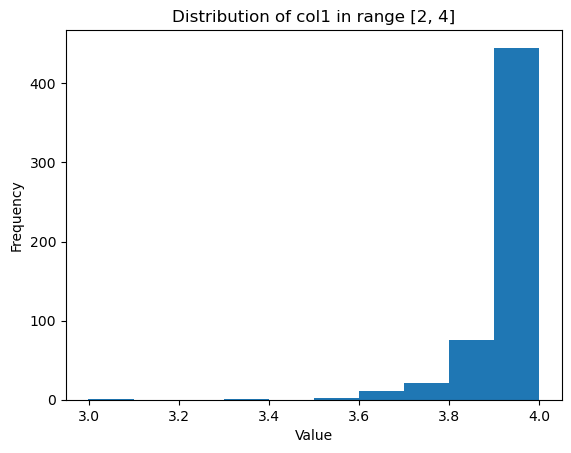

In [25]:
# filter DataFrame to values in range [2, 4]
subset = BS.loc[(BS['Backward_Similarity'] >= 2) & (BS['Backward_Similarity'] <= 4), 'Backward_Similarity']

# draw histogram of 'col1' column in subset
plt.hist(subset)

# add axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of col1 in range [2, 4]')
plt.show()

## Forward Similarity

In [26]:
FS = SIM.loc[[i for i in SIM.index if i[1] == 2001], [j for j in SIM.columns if j[1][1] > 2001]].sum(axis=1).to_frame('Forward_Similarity')


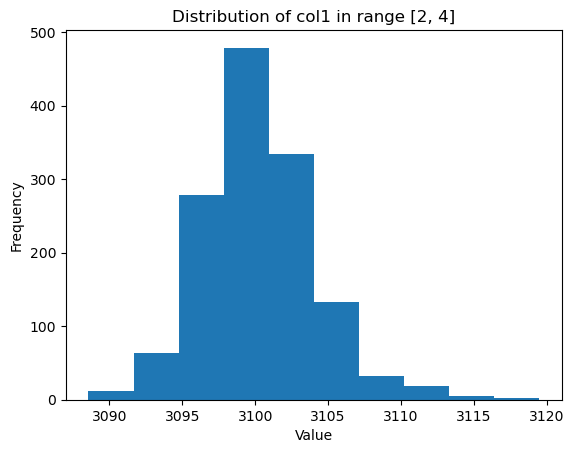

In [27]:
# filter DataFrame to values in range [2, 4]
subset = FS.loc[(FS['Forward_Similarity'] >= 2500) & (FS['Forward_Similarity'] <= 44444), 'Forward_Similarity']

# draw histogram of 'col1' column in subset
plt.hist(subset)

# add axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of col1 in range [2, 4]')
plt.show()

In [28]:
FS

,Forward_Similarity
patent_a,
"(6169074, 2001)",3100.385474
"(6169383, 2001)",3097.744490
"(6169549, 2001)",3109.320052
"(6169959, 2001)",3099.232407
"(6169960, 2001)",3099.013000
...,...
"(6334125, 2001)",3102.206149
"(RE37195, 2001)",3.016249
"(RE37245, 2001)",3.038611


# factor of importance

In [29]:
FOI = FS.merge(BS, left_index=True, right_index=True)
FOI['patent_importance']=FOI.Forward_Similarity/FOI.Backward_Similarity
FOI=FOI[FOI.patent_importance!=np.inf]
FOI

,Forward_Similarity,Backward_Similarity,patent_importance
patent_a,,,
"(6169074, 2001)",3100.385474,3.987640,777.498829
"(6169383, 2001)",3097.744490,4.062762,762.472480
"(6169549, 2001)",3109.320052,4.017604,773.924068
"(6169959, 2001)",3099.232407,3.894351,795.827719
"(6169960, 2001)",3099.013000,4.043143,766.486207
...,...,...,...
"(6334096, 2001)",3097.651151,3.966152,781.021788
"(6334102, 2001)",3095.585649,4.027700,768.574007
"(6334110, 2001)",3103.295646,4.045677,767.064563


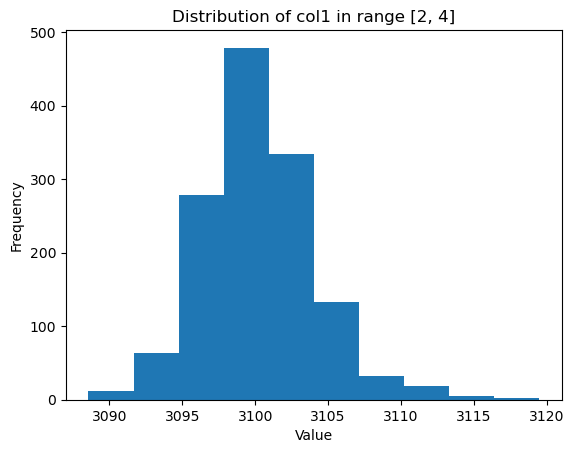

In [30]:
subset = FOI.loc[(FOI['patent_importance'] >= 2) & (FOI['patent_importance'] <= 44444), 'Forward_Similarity']

# draw histogram of 'col1' column in subset
plt.hist(subset)

# add axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of col1 in range [2, 4]')
plt.show()